# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- l-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 25th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 25 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Yu"
ln1 = "Xiang"
fn2 = "Jean"
ln2 = "Babin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_xiang_yu_and_babin_jean.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [3]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [4]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


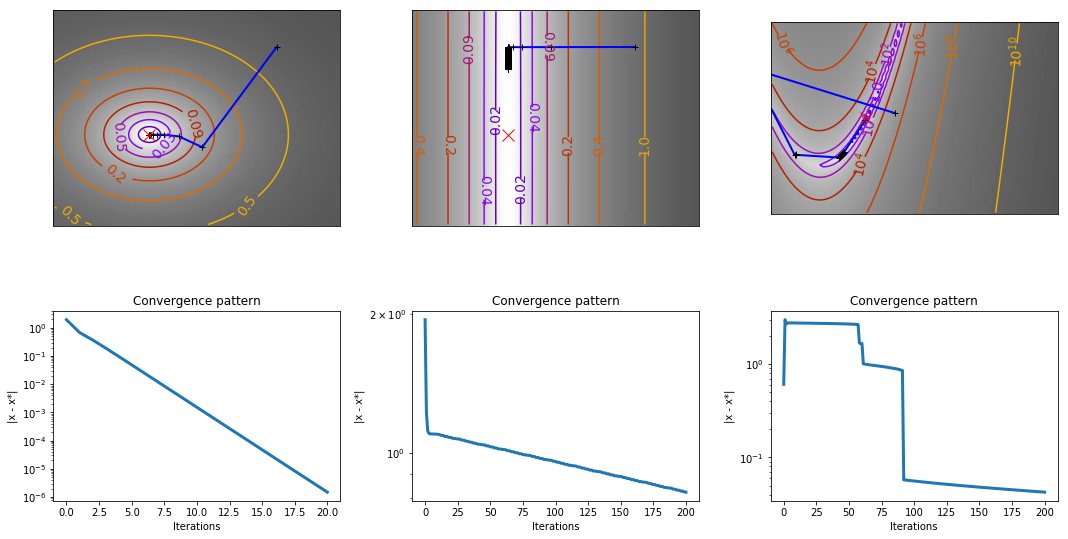

In [5]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 2: Implement Newton method

Implement Newton's method. Beware that the Hessian SHOULD be regularized !

**You are expected to comment** what you see. Play with the parameters. Do not describe the curves, rather

In [6]:
from scipy import linalg
from scipy.sparse.linalg import cg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
#     c1 = 1e-6
#     c2 = 1- 1e-6
    max_iter = 100
    lambda_threshold = 0.0001 
    
    #lambda_threshold = 0.1
    # regularization threshold
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        # Compute the Hessian, regularize it and compute the search direction d
        
        eigenvalues, eigenvectors = np.linalg.eigh(f_hessian(x))
        
        
        if eigenvalues[0] < lambda_threshold: 
            H = f_hessian(x) + (lambda_threshold - eigenvalues[0]) * np.identity(len(eigenvalues))
        else: 
            H = f_hessian(x)  
        d = - np.linalg.solve(H, grad_x)
        
        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            #print (all_x_k)
            #print (all_f_k)
            break
            

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


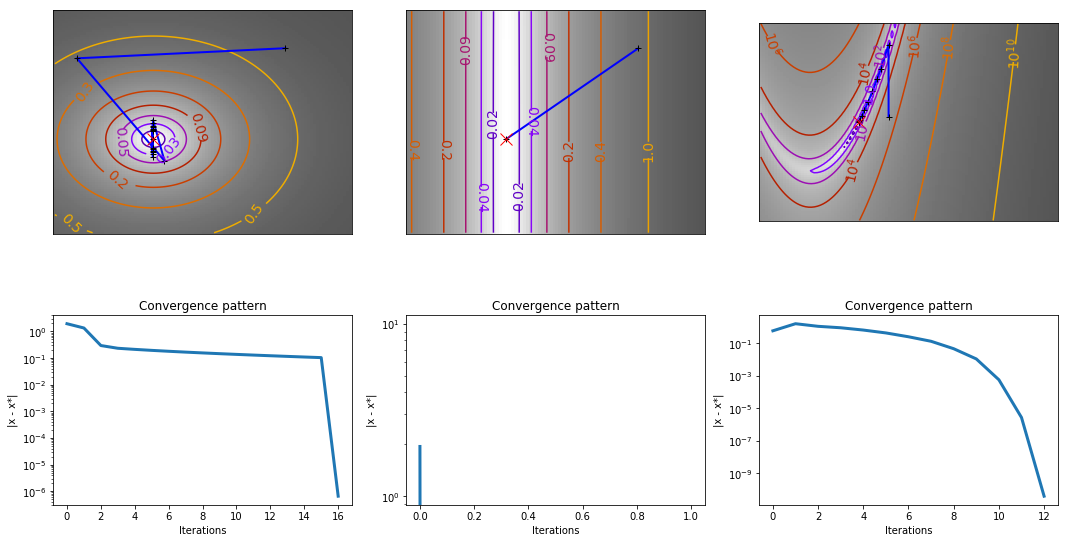

In [7]:
test_solver(newton)

**COMMENTS HERE**

Compared to the gradient method, Newton methods converges much faster, the objective function is evaluated much lesser. Newton method (with proper regularizing) with line search could also guarantee the monotonically decreasing of the objective function (not plotted above). Please notice the measure of Euclidean distance betweeen $x_k$ and $x^*$ are not equilvalent to the measure of the objective function $f(x_k)$, please refer to case 3 description. 

** For case 1:** A non convex Gaussian kernel ($f(x)=−exp(−x^2)$). Clearly, the optimal point is $x^* = [0,0]$. We could saw at the initial several iterations, only slight improvements happen with each step. This is because, when the initial point is far away from the optimal solution and the objective function is not convex ($Hessian = \frac{2 - 4 x^2}{\exp(x^2)} < 0$ for all $x$ far away from $x^*$ ), Newton method (without regularizing) will not converge for the original problem. However, since we add a regularizer, the search direction will always go to a decreasing direction, that is why we see the error is always decreasing. At the initial several steps, the improvement is small because we choose the regularizer to be very small. However, when the iteration came to a point which is close to the optimal $x^*$, the obejective function is locally convex near the optimal point, and the Hessian matrix is positive-definite locally, therefore no regularizer is added at the end of the iterations, then the Newton method converges in a single step. 

Besides, the parameter c1 and c2 also plays a significant role here, c1 is chosen to be small (no smaller than and close to zero) and to ensure that the step length $\alpha_k$ decreases objective function $f$ 'sufficiently', and c2 is chosen to be large (no larger than  but close to one) and  ensure that the slope has been reduced sufficiently.




**For case 2:** a strongly convex quadratic function.  The Newton method converges and always converges in a single step for strongly convex quadratic problem, and it does not depend on the conditionning. That is why we see afer one iteration(the second figure of the Convergence Pattern), the model converges. The gradient method, on the other hand, depends on the conditioning and that is why we saw slow convergence for ill-conditoned quadratic problem with gradient method.


**For case 3:** Rosenbrock function. We saw that the error increases slightly in the intial step and then gradually decreases. This is because Rosenbrock function is a non-convex function, and  global minimum is inside a long, narrow, parabolic shaped flat valley. The Newton method is an iterative method to find $x$ to converge to $x^*$, measured by the objective function, i.e. Rosenbrock function. The decreasing of Rosenbrock function does not necessarily mean the decreasing of the Euclidean distance betweeen $x$ and $x^*$. That is what we observed in the top right graph above, the initial point $x_0$ is much closer to $x^*$ by Euclidean distance compared to the point found after one iteration, i.e. the point $x_1$. However, we could see the point $x_1$ is in the valley, and measure by Rosenbrock function, it is much closer to $x^*$ than $x_0$. 

Newton methods use a local quadratic approximation to compute the jump direction. Rosenbrock function with Newton method converges relatively slow as in each iteration it only finds the optimal point locally, and with each step, it could move near the optimal solution, and that is why we do not observe a single step convergence when the found point $x_k$ is already close to $x^*$. 



**In summary**, Newton method performs really well when the Hessian matrix is available, it converges for convex function and  also for non-convex function if approporiate regularizer is added. 


# Part 2: Implement DFP algorithm

Now, implement the DFP algorithm using the formula for $B$ in the slides.

**Comment on what you observe**. Focus on the explanation, not on describing the curves! 

Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?

In [8]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation
        
        ssT = np.outer(s, s)   # this is a n * n matrix
        sTy = s.dot(y)   # this is a scalar
        
        ByyTB = np.outer(B.dot(y),y).dot(B)  # this is a matrix
        yTBy = y.dot(B).dot(y)  # this is a scalar
        
        B += ssT / sTy -  ByyTB / yTBy  # update B
        
        # TODO B = ...
        
        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


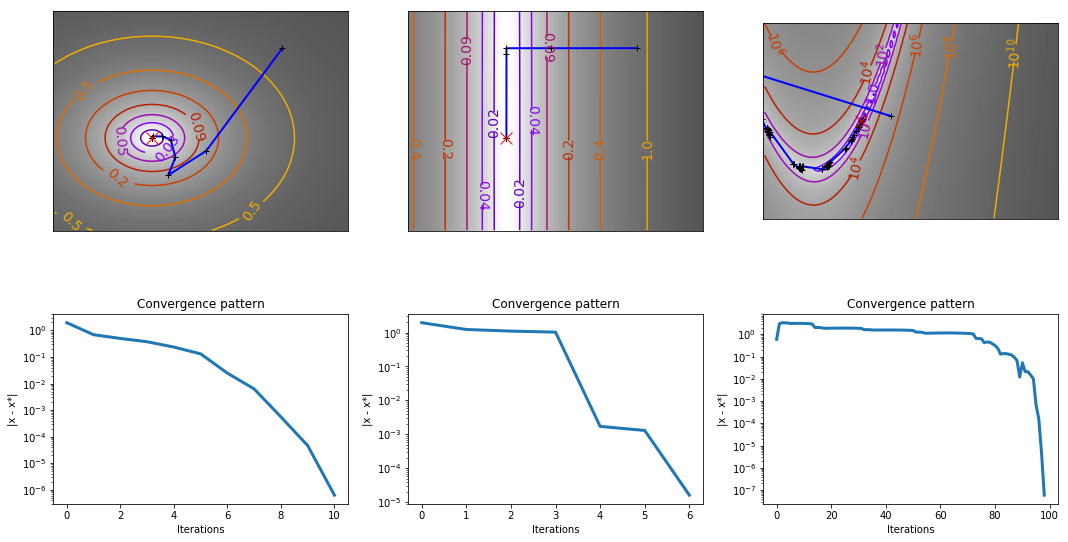

In [9]:
test_solver(dfp)

#### Your comments here

As we could see, DFP method works well for all three cases and all converges to the optimal solution in relatively a few iterations. I.e. it converges faster than gradient method.  But it have different performace with the Newton method case by case. The performace is measured by the number of iterations (not the running time). 

First, compared to Newton method, we do not observe the single step convergence for Case 2 or Case 1 (after a number of iterations). This is because the Hessian(or more precisely the inverse Hessian) from DFP method is an approximation instead of an exact calculation. Therefore, in each step, the jump direction is the result of a local approximation of inverse Hessian and the gradient. And the approximated inverse Hessian is positive, and DFP together with line seach could guarantee the monotonically decreasing of the objective function. I.e. the jump direction is guaranteed to be a decresing direction, but it could not guaranteed to be the steepest decrease for DFP method with the calculated jump direction and step size. That is why we observe a gradually decreasing of the objective function for all three cases. 

Besides, Since the initial inverse Hessian matrix is initilized as an Identity matrix,which means DFP method is reduced to steepest descent method at the first iteration. 

**Case 1:** We see DFP method performs better than the Newton method for this case. Especially in the first iteration, DFP method moves towards $x^*$ much faster than the Newton Method. This is becaue at the first iteration DFP is the same as steepest descent method. And for the several iterations after the first, DFP and Newton method are essentially the same, both construct an pos.def. matrix as an extimation of the original (inverse)Hessian matrix. 
While for DFP, the approximation matrix is constructed interatively with the Secant condition satisfied. While for Newton, the original Hession is regularized(the Hessain of Gaussian kernel is not positively definite near the starting point). 

And we also know Gaussian kernel is locally positively definite around $x^*$, therefore Newton method will not add regularizer for pos.def. Hessian in the last iteration (when $x_k$ comes close to $x^*$) and the updated Hessian is exact the Hessian of the objective function, and therefore we observe direct convergence at this step. This is why we observe a sudden jump in the error in the last iteration for Newton method. 

However, for DFP method, the Hessian is always an estimation, and not an exact calculation. I.e we are actually trying to solve a local quadratic approximation to compute the jump direction, and since it is an esimation, mostly we won't see the sudden jump in error as the Newton method. 

In Case 1, DFP method performs better than the Newton method, but it does not mean DFP method always perform better since as analyzed in Case 2 of Part 1, Newton method will have a one step convergence for convex quadratic problem. DFP, on the other hand, will not have such performance. That is what we exactly observed for Case 2. 


**Case 2:** The DFP method performs worse than the Newton method. Since the Hessian is estimated in DFP method, we are actually solving am approximated problem to the original problem. It will still converge very fast since the approximation is good enough and preserve the Secant condition. The solution in each step will always have relatively good improvement and in the end, the approximated problem will have the same solution to the original problem. 

There is no contradiction on the quadratic functions with what we've seen in class. In class, we said that DFP methods converges in p + 1 iterations on a quadratic problem. However, DFP is high sensitive to inaccurancies in line search. That may explain why it converges in more than p + 1 iterations in this case. 

Since the problem is ill-conditioned, the DFP method will find the optimal solution along one dimension (where the corresponding eigenvalue is big) very quickly, however on another dimension (the eignenvalue is small) relatively slow. That is why we see $x_k$ reach optimal for one dimension after one iteration, but gradually improve over the other dimension with iterations. 

**Case 3:** Since Rosenbrock function is a non-convex function, and global minimum is inside a long, narrow, parabolic shaped flat valley. In the first iteration, with the given inital point in our example, the DFP method found a point that is far away from the initial point (following the steepest descent method in the first iteration). 

However, Newton method is actually trying to find a decreasing direction within the neighbourhod of the intial point at the intial step. And that is why we observed quite different points after the first iteration for Newton method and DFP method. 

Later, for DFP method, we see that the estimation of $B$ is updated, the updated points are actually always in the valley, which means that the approximation is good and DFP always lead to the global minimum along the valley.  



# Part 3: Implement BFGS algorithm

You should now implement BFGS, using the formula for $B_t$ seen in the slides.

**Comment** on what you see.

In [10]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = -np.dot(B, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation
        
        rho_t = 1 / y.dot(s) # this is a scalar
        
        rsyT = rho_t * np.outer(s, y)  # this is a matrix
        rysT = rho_t * np.outer(y, s)  # this is a matrix
        rssT = rho_t * np.outer(s, s)  # this is a matrix
        size_n = len(y)
        
        B = (np.identity(size_n) - rsyT).dot(B).dot(np.identity(size_n) - rysT) + rssT      
        
        # TODO B = 
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


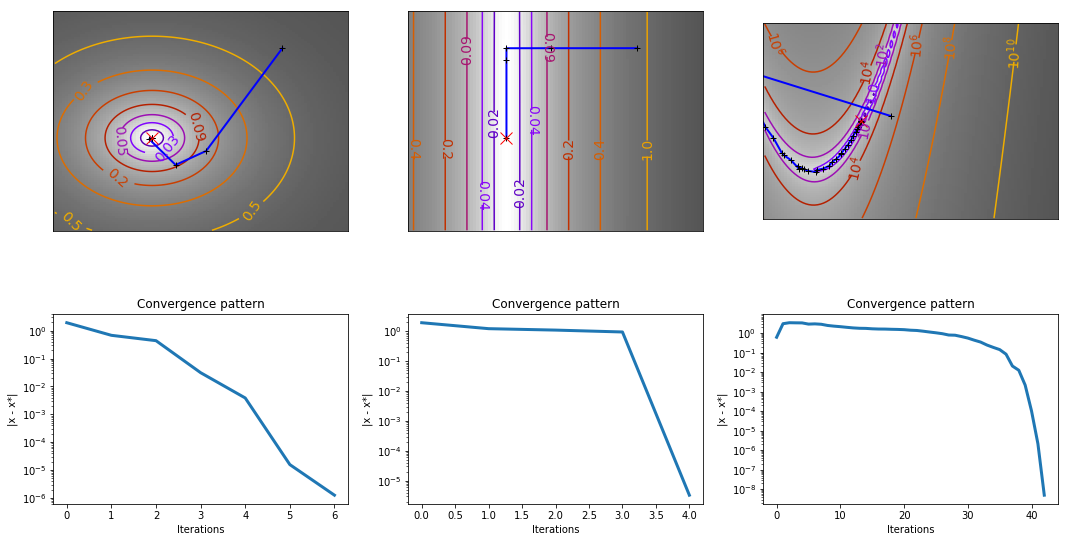

In [11]:
test_solver(bfgs)

#### Your comments here

BFGS is almost the same as DFP, only the updating of H/B is different. Moreover, BFGS is less sensitive than DFP to errors in the line-search, therefore more efficient and have better performance. And we can compare the result of these two methods, they almost follow the same pattern, only that BFGS converges faster than DFP. 

# Part 3: Implement l-BFGS algorithm

You should now implement the l-BFGS algorithm. First, code the two-loops recursion:

In [12]:
def two_loops(grad_x, m, s_list, y_list, rho_list, B0):
    '''
    Parameters
    ----------
    
    grad_x : ndarray, shape (p,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    rho_list : list of length m
        the past m values of rho
        
    B0 : ndarray, shape (p, p)
        Initial inverse Hessian guess
    
    Returns
    -------
    
    r :  ndarray, shape (p,)
        the L-BFGS direction
    '''
    
    # print (np.shape(grad_x), np.shape(s_list), np.shape(y_list), np.shape(rho_list), np.shape(B0))
    q = grad_x.copy()  # vecotor, p: number of parameters xs,  p * 1
    
    nr_m = len(y_list) # y_t = g_{t+1} - g_t, y_list: list length m, each element p * 1
    
    alphas = np.zeros(nr_m)  
    
    # TODO : first loop
    for i in range( int(nr_m -1), -1, -1): 
        alphas[i] = np.dot(rho_list[i] * s_list[i], q)   # this is a scalar, rho_list[i] = 1 / y_t.T * s_t, is a scalar   
        q -= alphas[i] * y_list[i]    # this is a vector, p * 1

    r = np.dot(B0, q)
    # TODO: second loop
    for i in range(nr_m): 
        beta = rho_list[i] * np.dot(y_list[i], r)
        r += np.dot(alphas[i] - beta,  s_list[i])   # s_t = x_{t+1} - x(t), p*1
        
    return -r

In [13]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, rho_list = [], [], []
    
  
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, rho_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
           
            
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        rho = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        rho_list.append(rho)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            rho_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


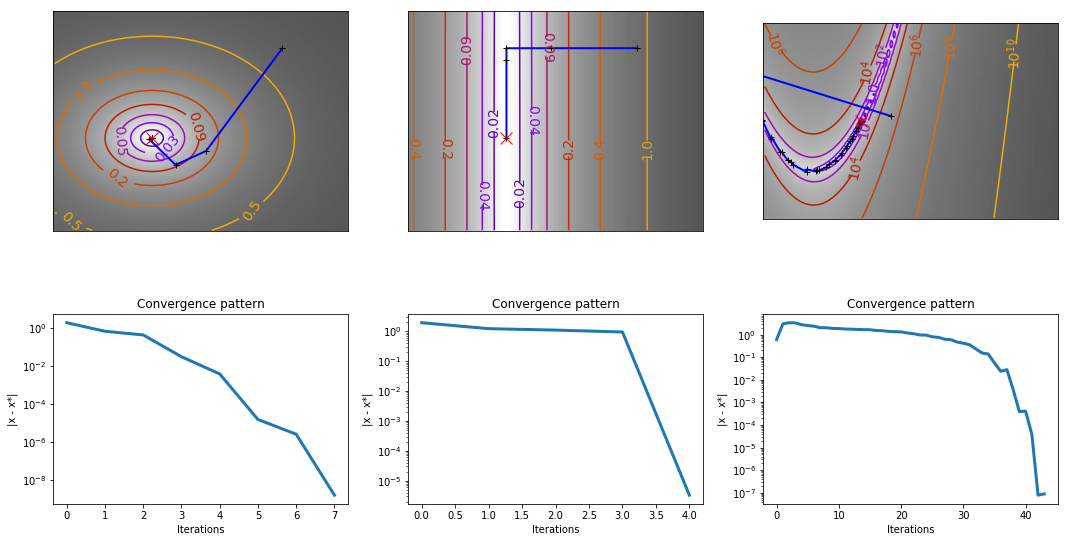

In [14]:
test_solver(lbfgs)

**Comment on what you observe**

The performance of lbfgs is almost identical as bfgs for all three test cases.

But we do observe that for lbfgs: 

- We do not store the whole Hessian in memory, just m values of $s_t$ and $y_t$.
- The decreasing direction is found by computing $d$ with iterations in a loop. 
- We do drop out (forget) the the outdated landscape (as reflected in the code e.g. y_list.pop(0))


Since our test cases are very small, it is hard to estimate exactly the effect of the memory cost. But according to above therectically advantange, lbfgs should have superior performace over bfgs for large scale problem. 

Besides, we notice B0 is intialized as Identity matrix in lbfgs, it could be further improved at each iteration so that the initilized B0 is close to the actual matirx, and we may improve the performance.